In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_lambdas_autoencoder, train_lambdas_cov
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [3]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")
labels_all = np.load("../data/labels/filtered_y_train_all_fates.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


### checking if data is the same

In [4]:
filtered_images_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_images.npy")
filtered_tracks_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_tracks.npy")
filtered_labels_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filteresd_y_train.npy")

In [4]:
np.unique(np.nonzero(images[:,0,:,:] != filtered_images_previous)[0])

array([], dtype=int64)

In [7]:
np.unique(np.nonzero(tracks[:,0,0:5] != filtered_tracks_previous[:,0:5])[0])

array([], dtype=int64)

In [117]:
def normalize_images_per_frame(cell_images):
    """
    Normalize donor and acceptor channels to preserve their ratio in each frame.
    
    Parameters:
    - cell_images (numpy array): Array of shape (cell, time, height, width).
    
    Returns:
    - normalized_images (numpy array): Normalized array of the same shape.
    """
    # Find the absolute maximum value across all cells and channels
    cell, frame, channel, height, width = cell_images.shape
    normalized_images = np.zeros_like(cell_images)

    for j in range(frame):
        absolute_max = np.max(cell_images[:,j])
        normalized_images[:,j] = cell_images[:,j] / absolute_max
        
    return normalized_images

In [116]:
images.shape

(1385, 1080, 2, 20, 20)

In [118]:
# normalise and then fret

norm_images = normalize_images_per_frame(images)
fret_images = norm_images[:,:,0,:,:] / norm_images[:,:,1,:,:] 
fret_images = np.nan_to_num(fret_images, nan=0.0)


/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_70149/4253590529.py:4: RuntimeWarning: invalid value encountered in divide
  fret_images = norm_images[:,:,0,:,:] / norm_images[:,:,1,:,:]


In [120]:
def normalize_images_per_frame(cell_images):
    """
    Normalize donor and acceptor channels to preserve their ratio in each frame.
    
    Parameters:
    - cell_images (numpy array): Array of shape (cell, time, height, width).
    
    Returns:
    - normalized_images (numpy array): Normalized array of the same shape.
    """
    # Find the absolute maximum value across all cells and channels
    cell, frame, height, width = cell_images.shape
    normalized_images = np.zeros_like(cell_images)

    for j in range(frame):
        absolute_max = np.max(cell_images[:,j])
        normalized_images[:,j] = cell_images[:,j] / absolute_max
        
    return normalized_images

In [121]:
norm_images = normalize_images_per_frame(fret_images)

In [122]:
norm_images[0,0].max()

0.7094305052553326

## 2. Prepare for model training

### 1. FRET ratio calculation

In [124]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] 
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_70149/3830351353.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:]


In [19]:
fret_images[100,0].max()

1.2451456310679612

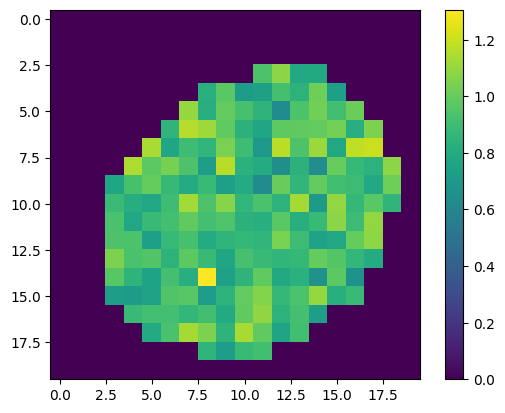

In [23]:
plt.imshow(fret_images[0,1001,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [125]:
norm_images = normalize_images_per_frame(fret_images)

In [25]:
norm_images[0,0].max()

0.7094305052553326

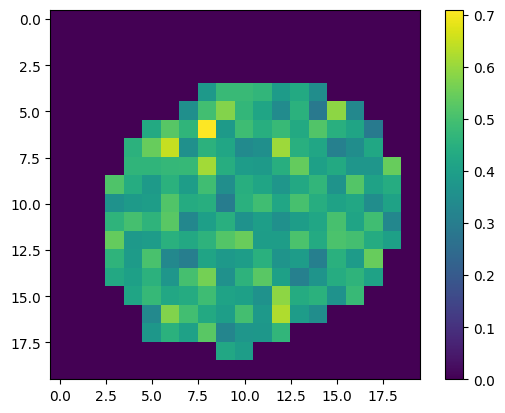

In [115]:
plt.imshow(norm_images[0,0,:,:])
plt.colorbar()

### 3. Center cells

In [126]:
centered_images = center_cells(norm_images)

In [127]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_cell_data(cells_array, cell_fate, test_size=0.2, random_state=42):
    """
    Preprocess cell data with train-test split and data augmentation
    
    Parameters:
    - cells_array: numpy array (cells, height, width)
    - cell_fate: numpy array of fate labels
    - test_size: proportion of data to use for testing
    - random_state: random seed for reproducibility
    
    Returns:
    - X_train, X_test: augmented and split image data
    - y_train, y_test: corresponding labels
    - train_indices, test_indices: original indices used for splitting
    """
    # Get unique fates and their counts
    unique_fates, fate_counts = np.unique(cell_fate, return_counts=True)
    
    # Find the minority and majority class
    minority_fate = unique_fates[np.argmin(fate_counts)]
    majority_fate = unique_fates[np.argmax(fate_counts)]
    
    # Split indices while maintaining class distribution
    train_indices, test_indices = train_test_split(
        np.arange(len(cell_fate)), 
        test_size=test_size, 
        stratify=cell_fate, 
        random_state=random_state
    )
    
    # Separate training data by fate
    train_minority = train_indices[cell_fate[train_indices] == minority_fate]
    train_majority = train_indices[cell_fate[train_indices] == majority_fate]
    
    # Data augmentation for minority class
    augmented_minority = []
    augmented_minority_labels = []
    
    for idx in train_minority:
        cell = cells_array[idx]
        
        # Flip augmentations
        augmented_minority.extend([
            cell,  # original
            np.flip(cell, axis=0),  # vertical flip
            np.flip(cell, axis=1),  # horizontal flip
            np.flip(cell)  # both flips
        ])
        augmented_minority_labels.extend([minority_fate] * 4)
    
    # Rotate augmentations (90, 180, 270 degrees)
    for idx in train_minority:
        cell = cells_array[idx]
        augmented_minority.extend([
            np.rot90(cell),
            np.rot90(cell, 2),
            np.rot90(cell, 3)
        ])
        augmented_minority_labels.extend([minority_fate] * 3)
    
    # Convert to numpy arrays
    augmented_minority = np.array(augmented_minority)
    augmented_minority_labels = np.array(augmented_minority_labels)
    
    # Adjust majority class sampling to avoid replacement issues
    max_majority_samples = len(train_majority)
    needed_majority_samples = len(augmented_minority_labels)
    
    if needed_majority_samples > max_majority_samples:
        # If we need more samples than available, use all majority samples
        selected_majority = train_majority
        
        # Repeat sampling if still not enough
        while len(selected_majority) < needed_majority_samples:
            additional_samples = np.random.choice(
                train_majority, 
                size=min(max_majority_samples, needed_majority_samples - len(selected_majority)),
                replace=True
            )
            selected_majority = np.concatenate([selected_majority, additional_samples])
    else:
        # Normal case: sample without replacement
        np.random.seed(random_state)
        selected_majority = np.random.choice(
            train_majority, 
            size=needed_majority_samples, 
            replace=False
        )
    
    # Trim or select exactly the number of samples needed
    selected_majority = selected_majority[:needed_majority_samples]
    
    # Combine augmented minority and selected majority
    X_train = np.concatenate([
        cells_array[train_minority],
        augmented_minority,
        cells_array[selected_majority]
    ])
    y_train = np.concatenate([
        cell_fate[train_minority],
        augmented_minority_labels,
        cell_fate[selected_majority]
    ])
    
    # Prepare test set
    X_test = cells_array[test_indices]
    y_test = cell_fate[test_indices]
    
    return X_train, X_test, y_train, y_test, train_indices, test_indices


In [129]:
X_train, X_test, y_train, y_test, train_idx, test_idx = preprocess_cell_data(centered_images[:,0], labels, test_size=0.2, random_state=42)

In [162]:
x_test_previous = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/centered_x_test.npy")

In [165]:
test_images.shape, x_test_previous.shape

((277, 1080, 20, 20), (277, 20, 20))

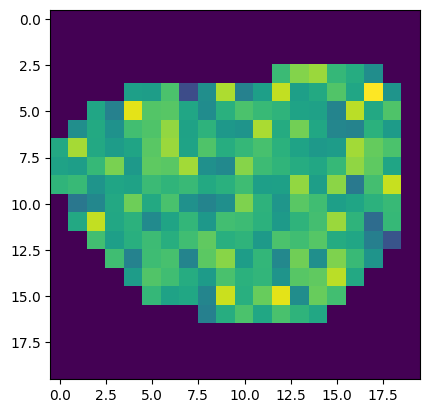

In [167]:
plt.imshow(x_test_previous[0])

In [185]:
for j in range(1079):
    if np.nonzero(x_test_previous[5] != test_images[5,j]) == []:
        print(j)

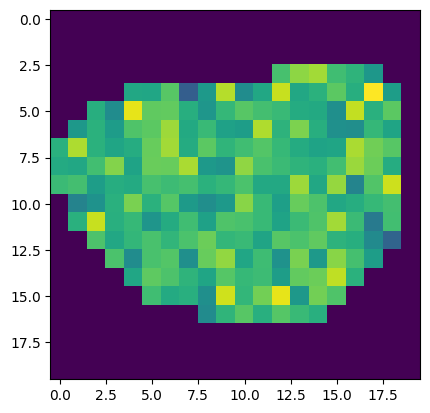

In [166]:
plt.imshow(test_images[0,0])

In [138]:
np.nonzero(X_test != x_test_previous)

(array([  0,   0,   0, ..., 276, 276, 276]),
 array([ 3,  3,  3, ..., 16, 17, 17]),
 array([12, 13, 14, ..., 15, 11, 12]))

In [ ]:
np.delete(processed_images, indexes_with_no_fret, axis=0)

In [131]:
indexes_with_no_fret = np.where(tracks[:,4:8][:,0] == 0.0)

In [130]:
X_train.shape

(2730, 20, 20)

### 4. Train-test split

In [27]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes]
train_labels = labels[train_indexes]
train_tracks = tracks[train_indexes]
test_images = centered_images[test_indexes]
test_labels = labels[test_indexes]
test_tracks = tracks[test_indexes]

In [32]:
test_images[:,0].max()

0.8816826454338641

In [12]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [2]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [8]:
train_images.shape

(1108, 1080, 20, 20)

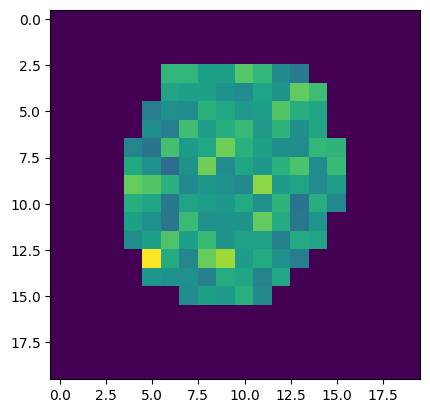

In [7]:
plt.imshow(train_images[0,0,:,:])

In [5]:
import numpy as np

def augment_dataset(cell_images, labels, augmentations, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to an image sequence.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Apply augmentations to each time frame of each cell sequence
    augmented_fate_0 = np.concatenate([augmentations(movie) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match the number of fate 1 samples
    target_count = len(fate_1_combined)
    balanced_fate_0 = fate_0_combined[np.random.choice(
        len(fate_0_combined), size=target_count, replace=len(fate_0_combined) < target_count
    )]

    # Merge balanced datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels

# **Augmentation function for time-series images**
def augmentations(movie):
    """
    Applies augmentations independently to each frame in a movie.

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).

    Returns:
        numpy.ndarray: Augmented images (new_axis is added to match input shape).
    """
    augmented_movies = []
    for frame in movie:
        augmented_frames = [
            np.flip(frame, axis=-1),  # Flip horizontally
            np.flip(frame, axis=-2),  # Flip vertically
            np.rot90(frame, k=1, axes=(-2, -1)),  # Rotate 90 degrees
            np.rot90(frame, k=2, axes=(-2, -1)),  # Rotate 180 degrees
            np.rot90(frame, k=3, axes=(-2, -1))  # Rotate 270 degrees
        ]
        augmented_movies.append(augmented_frames)

    return np.array(augmented_movies).transpose(1, 0, 2, 3)  # Shape (augments, time, height, width)


In [6]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

In [7]:
train_images_augmented.shape

(2184, 1080, 20, 20)

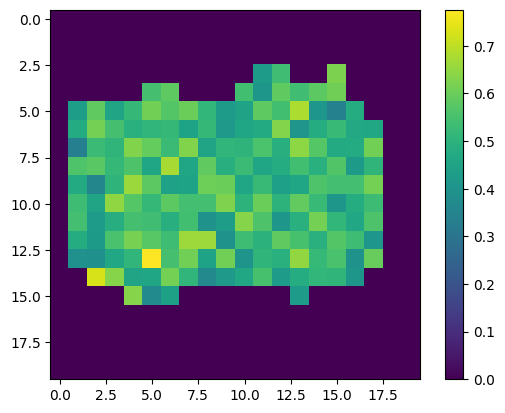

In [6]:
plt.imshow(train_images_augmented[0,0,:,:])
plt.colorbar()

In [64]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [ ]:
# np.save("../data/images/train_images_augmented.npy", train_images_augmented)
# np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)

In [7]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [8]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [67]:
more_stretched_x_train, more_stretched_x_test = stretch_intensities_global(stretched_x_train, stretched_x_test)

In [8]:
stretched_x_train, stretched_x_test_augmented = stretch_intensities_global(train_images_augmented, test_images_augmented)

In [9]:
np.save("../data/images/stretched_x_test_augmented.npy", stretched_x_test_augmented)

In [22]:
np.save("../data/images/train_images_augmented_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented_stretched.npy", stretched_x_test)
np.save("../data/labels/train_labels_augmented.npy", train_labels_augmented)
np.save("../data/labels/test_labels.npy", test_labels)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


In [21]:
stretched_x_train.min()

0.0

# Model Workflow - Training and Evaluation

In [163]:
train_images_augmented = np.load("../data/images/train_images_augmented_stretched.npy")
train_labels_augmented = np.load("../data/labels/train_labels_augmented.npy")
test_images = np.load("../data/images/test_images_augmented_stretched.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [4]:
train_images_augmented[100,0].max()

0.6389490739153574

In [55]:
len(np.nonzero(train_labels_augmented)[0])

1092

In [6]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 100
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(train_images_augmented)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

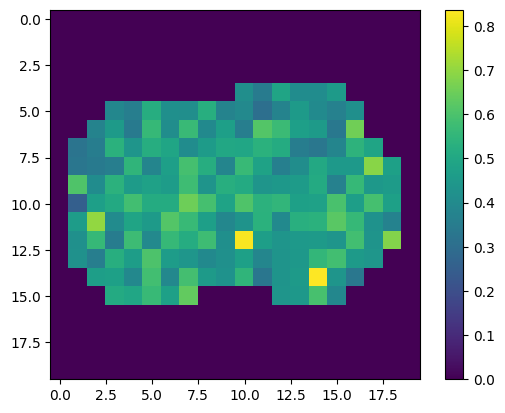

In [45]:
plt.imshow(stretched_x_train[0,3,:,:])
plt.colorbar()

In [181]:
stretched_x_test[:,0].max()

0.9234785721484119

Understanding difference between the previous x_test and new x_test

In [7]:
x_test_previous = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/centered_x_test.npy")

In [183]:
stretched_x_test.shape, x_test_previous.shape

((277, 1080, 20, 20), (277, 20, 20))

In [189]:
division = stretched_x_test[0,0,:,:] / x_test_previous[0,:,:]
division = np.nan_to_num(division, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_58879/174862282.py:1: RuntimeWarning: invalid value encountered in divide
  division = stretched_x_test[0,0,:,:] / x_test_previous[0,:,:]


In [192]:
difference = stretched_x_test[0,0,:,:] - x_test_previous[0,:,:]

In [194]:
difference

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.05898966, 0

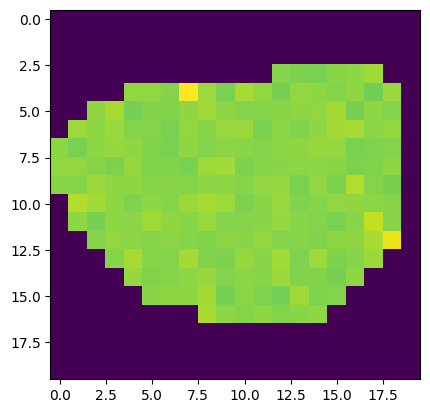

In [195]:
plt.imshow(division)

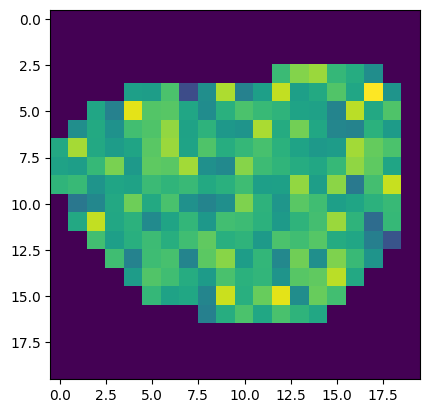

In [196]:
plt.imshow(x_test_previous[0,:,:])

In [ ]:
import numpy as np

def compute_transformation(I_prev_t0, I_new_t0):
    """
    Compute pixel-wise transformation parameters (scaling and offset)
    between previous and new images at t=0.
    """
    # Avoid division by zero: Replace zero std values with small number
    std_prev = np.std(I_prev_t0)
    if std_prev == 0:
        std_prev = 1e-8  # Small value to prevent division errors
    
    a = np.std(I_new_t0) / std_prev
    b = np.mean(I_new_t0) - a * np.mean(I_prev_t0)
    
    return a, b

def apply_transformation(I_new, a, b):
    """
    Apply the computed transformation to all time frames.
    I_new: [cells, time, height, width] (new intensity data)
    """
    I_corrected = (I_new - b) / a
    return I_corrected

# Example Usage
# I_prev and I_new should have shape [cells, time, height, width]
I_new = stretched_x_test     

# Get the first time frame
I_prev_t0 = x_test_previous  # Shape: [cells, height, width]
I_new_t0 = stretched_x_test[:, 0, :, :]    # Shape: [cells, height, width]

# Compute transformation per pixel
a, b = compute_transformation(I_prev_t0, I_new_t0)

# Apply transformation to the entire time series
I_corrected = apply_transformation(I_new, a, b)

# Save corrected images
#np.save("corrected_data.npy", I_corrected)


In [ ]:
import numpy as np

def compute_pixelwise_transformation(I_prev_t0, I_new_t0):
    """
    Compute pixel-wise transformation parameters (scaling and offset)
    between previous and new images at t=0.
    I_prev_t0 and I_new_t0 have shape (cells, height, width)
    """
    # Compute pixel-wise scaling factor a (avoid division by zero)
    a = np.where(I_prev_t0 != 0, I_new_t0 / I_prev_t0, 1.0)  # Element-wise division
    
    # Compute pixel-wise offset b
    b = I_new_t0 - a * I_prev_t0  # Ensures mapping: I_new_t0 = a * I_prev_t0 + b
    
    return a, b

def apply_pixelwise_transformation(I_new, a, b):
    """
    Apply the computed transformation to all time frames.
    I_new: [cells, time, height, width] (new intensity data)
    a, b: computed transformation parameters per pixel (cells, height, width)
    """
    # Expand dims of `a` and `b` to apply across time dimension
    a = np.expand_dims(a, axis=1)  # Shape: [cells, 1, height, width]
    b = np.expand_dims(b, axis=1)  # Shape: [cells, 1, height, width]
    
    # Apply transformation
    I_corrected = (I_new - b) / a
    return I_corrected

In [229]:
a.shape

(277, 20, 20)

In [215]:
a, b = compute_pixelwise_transformation(I_prev_t0, I_new_t0)

# Apply transformation to the entire time series
I_corrected = apply_pixelwise_transformation(I_new, a, b)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_58879/3366727535.py:10: RuntimeWarning: invalid value encountered in divide
  a = np.where(I_prev_t0 != 0, I_new_t0 / I_prev_t0, 1.0)  # Element-wise division


In [236]:
train_indexes_137, test_indexes_137 = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes_137]
train_labels = labels[train_indexes_137]
train_tracks = tracks[train_indexes_137]
test_images = centered_images[test_indexes_137]
test_labels = labels[test_indexes_137]
test_tracks = tracks[test_indexes_137]

In [239]:
train_137, test_137, y_train_137, y_test_137 = train_test_split(centered_images, labels , test_size=0.2, random_state=137)


In [240]:
train_137.shape

(1108, 1080, 20, 20)

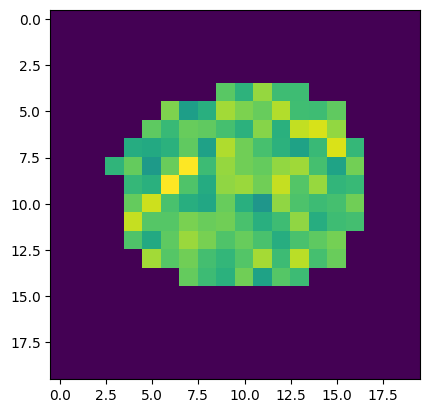

In [241]:
plt.imshow(train_137[0,0,:,:])

In [9]:
x_train_previous = np.load("/Users/inescunha/Documents/GitHub/CellFate/data/centered_x_train.npy")

In [245]:
x_train_previous.shape

(2184, 20, 20)

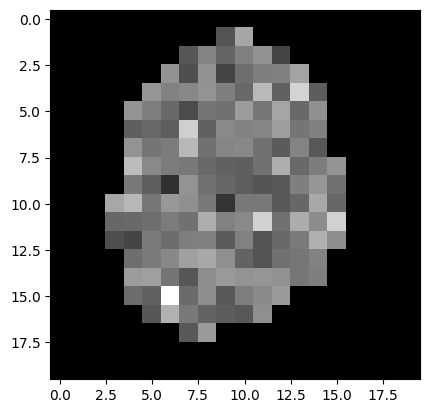

In [252]:
plt.imshow(x_train_previous[0], cmap='gray')

In [243]:
stretched_x_train.shape

(2184, 1080, 20, 20)

In [ ]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    frame = 0
    def plot_frame(cell):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, cell=IntSlider(min=0, max=2183, step=1, value=0)) # max=images.shape[0] - 1

display_movie(stretched_x_train)

interactive(children=(IntSlider(value=0, description='cell', max=2183), Output()), _dom_classes=('widget-inter…

In [276]:
np.where(np.round(x_test_previous, 5) != np.round(I_corrected[:,0], 5))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [281]:
a.shape

(277, 20, 20)

In [273]:
I_corrected[0,0][5,5]

0.44213366736945314

In [274]:
x_test_previous[0][5,5]

0.4421336673694531

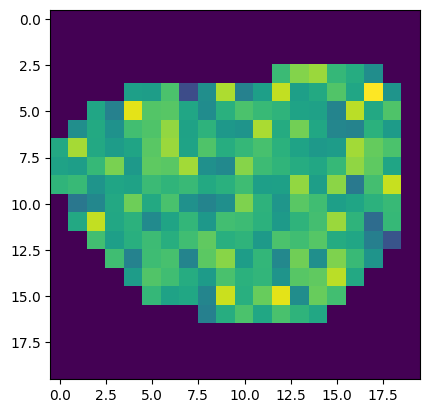

In [ ]:
plt.imshow(I_corrected[0,0])

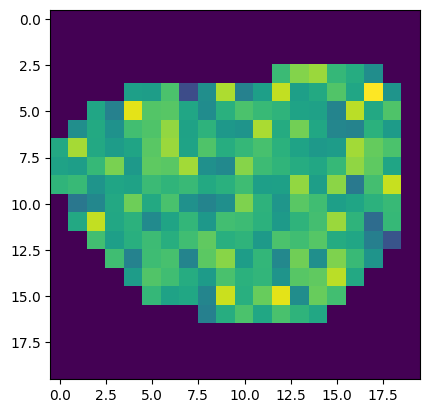

In [258]:
plt.imshow(x_test_previous[0])

In [242]:
train_137[:,0].max()

0.8816826454338641

In [235]:
train_images.shape

(1108, 1080, 20, 20)

In [216]:
I_corrected[:,0].max()

0.8596905079691756

In [217]:
I_corrected[0,0].min()

0.0

In [ ]:
I_corrected

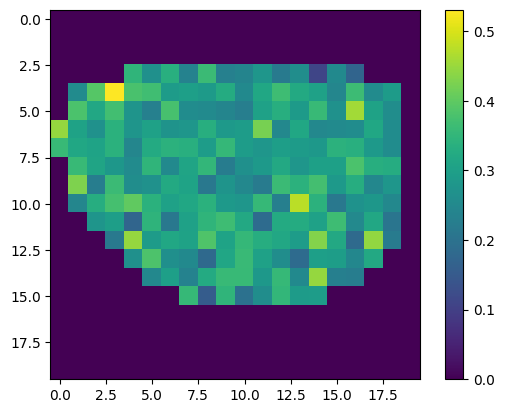

In [302]:
plt.imshow(I_corrected[0,100])
plt.colorbar()

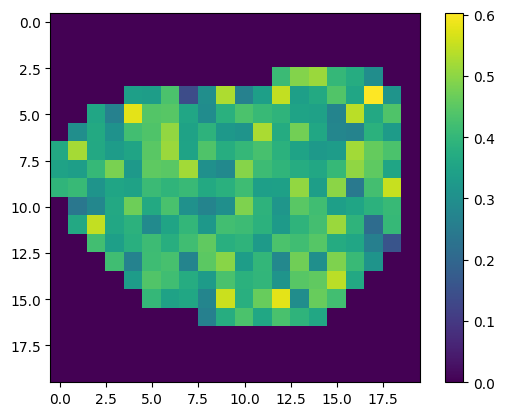

In [300]:
plt.imshow(x_test_previous[0])
plt.colorbar()

In [201]:
I_prev_t0.max()

0.8596905079691756

Matching X_train indexes

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

def compute_cell_areas_and_masks(X):
    """
    Compute the area of each cell and its spatial mask.
    X shape: (num_cells, time, height, width)
    Returns:
      - areas: (num_cells,) array of computed areas
      - masks: (num_cells, height, width) binary mask of cell positions
    """

    # Compute cell area as the count of nonzero pixels
    areas = np.sum(X > 0, axis=(1, 2))

    # Compute binary masks (1 where cell is, 0 otherwise)
    masks = (X > 0).astype(np.uint8)  # Shape: (num_cells, height, width)

    return areas, masks

def iou(mask1, mask2):
    """
    Compute the Intersection over Union (IoU) between two binary masks.
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0  # Avoid division by zero

def match_cells(prev_X, new_X):
    """
    Match cells between previous and new datasets using area and spatial mask similarity.
    Returns:
      - matches: (num_cells,) array where matches[i] gives the index of prev_X[i] in new_X.
    """
    prev_areas, prev_masks = compute_cell_areas_and_masks(prev_X)
    new_areas, new_masks = compute_cell_areas_and_masks(new_X)

    matches = np.full(prev_X.shape[0], -1, dtype=int)  # Initialize with -1 (no match)

    for i, (prev_area, prev_mask) in enumerate(zip(prev_areas, prev_masks)):
        # Find candidate cells in new_X with the same area
        candidate_indices = np.where(new_areas == prev_area)[0]

        if len(candidate_indices) == 1:
            # Unique match found
            matches[i] = candidate_indices[0]
        else:
            # Compare masks using IoU
            iou_scores = [iou(prev_mask, new_masks[j]) for j in candidate_indices]
            
            if len(iou_scores) > 0:
                best_match_idx = candidate_indices[np.argmax(iou_scores)]  # Best IoU match
                matches[i] = best_match_idx

    return matches


In [78]:
def get_nonzero_positions(X):
    """
    Get a set of non-zero pixel positions for each cell.
    Returns a list where each entry is a frozenset of (x, y) coordinates.
    """
    nonzero_positions = []
    for cell in X:
        positions = np.argwhere(cell > 0)  # Find non-zero (x, y) positions
        nonzero_positions.append(frozenset(map(tuple, positions)))  # Store as a frozenset
    return nonzero_positions

def match_indexes(prev_X, new_X):
    """
    Match cells between prev_X and new_X based on exact non-zero pixel positions.
    Returns a list where index i in prev_X maps to index j in new_X.
    """
    prev_positions = get_nonzero_positions(prev_X)
    new_positions = get_nonzero_positions(new_X)

    # Create a mapping from new_positions to their indices
    new_pos_to_index = {pos: i for i, pos in enumerate(new_positions)}

    # Match indices
    matched_indices = []
    for i, prev_pos in enumerate(prev_positions):
        if prev_pos in new_pos_to_index:
            matched_indices.append(new_pos_to_index[prev_pos])
        else:
            matched_indices.append(None)  # No match found

    return matched_indices

In [99]:
def get_nonzero_positions(X):
    """
    Returns a list where each entry is an array of (x, y) coordinates
    of the non-zero pixels in the first frame of each cell.
    """
    nonzero_positions = []
    for cell in X:
        frame0 = cell  # Extract first frame
        positions = np.argwhere(frame0 > 0)  # Find non-zero (x, y) positions
        nonzero_positions.append(positions)
    return nonzero_positions

def match_indexes(prev_X, new_X, max_shift=2):
    """
    Match cells between prev_X and new_X based on non-zero pixel positions,
    allowing small shifts in pixel positions.

    Returns a list where index i in prev_X maps to index j in new_X.
    """
    prev_positions = get_nonzero_positions(prev_X)
    new_positions = get_nonzero_positions(new_X)

    matched_indices = [-1] * len(prev_positions)  # Initialize with -1 (no match)

    for i, prev_pos in enumerate(prev_positions):
        best_match = None
        best_distance = float("inf")

        for j, new_pos in enumerate(new_positions):
            # Compute the pairwise distances between all nonzero pixels
            dist_matrix = cdist(prev_pos, new_pos, metric="euclidean")

            # If the closest match is within max_shift pixels, consider it a match
            if dist_matrix.size > 0 and np.min(dist_matrix) <= max_shift:
                avg_dist = np.mean(np.min(dist_matrix, axis=1))  # Mean distance to closest match
                if avg_dist < best_distance:
                    best_distance = avg_dist
                    best_match = j

        if best_match is not None:
            matched_indices[i] = best_match  # Assign best match

    return matched_indices

In [100]:
prev_positions = get_nonzero_positions(x_train_previous)
new_positions = get_nonzero_positions(train_images_augmented[:,0])

print("First cell in prev_X non-zero positions:\n", prev_positions[0])
print("First cell in new_X non-zero positions:\n", new_positions[0])

First cell in prev_X non-zero positions:
 [[ 1  9]
 [ 1 10]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 11]
 [ 6 12]
 [ 6 13]
 [ 6 14]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 8 11]
 [ 8 12]
 [ 8 13]
 [ 8 14]
 [ 8 15]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]
 [ 9 13]
 [ 9 14]
 [ 9 15]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [10  7]
 [10  8]
 [10  9]
 [10 10]
 [10 11]
 [10 12]
 [10 13]
 [10 14]
 [10 15]
 [11  3]
 [11  4]
 [11  5]
 [11  6]
 [11  7]
 [11  8]
 [11  9]
 [11 10]
 [11 11]
 [11 12]
 [11

In [98]:
def get_nonzero_positions(X, threshold=1e-6):
    """Returns a list of non-zero pixel positions for each cell in X."""
    positions = []
    for i in range(X.shape[0]):  # Loop over cells
        binary_mask = X[i] > threshold  # Use only the first frame
        nonzero_coords = np.argwhere(binary_mask)  # Get (x, y) indices
        positions.append(nonzero_coords)
    return positions

prev_positions = get_nonzero_positions(x_train_previous)
new_positions = get_nonzero_positions(train_images_augmented[:,0])

print("First cell in prev_X non-zero positions:\n", prev_positions[0])
print("First cell in new_X non-zero positions:\n", new_positions[0])


First cell in prev_X non-zero positions:
 [[ 1  9]
 [ 1 10]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 12]
 [ 4 13]
 [ 4 14]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 11]
 [ 6 12]
 [ 6 13]
 [ 6 14]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 8 11]
 [ 8 12]
 [ 8 13]
 [ 8 14]
 [ 8 15]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [ 9 11]
 [ 9 12]
 [ 9 13]
 [ 9 14]
 [ 9 15]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [10  7]
 [10  8]
 [10  9]
 [10 10]
 [10 11]
 [10 12]
 [10 13]
 [10 14]
 [10 15]
 [11  3]
 [11  4]
 [11  5]
 [11  6]
 [11  7]
 [11  8]
 [11  9]
 [11 10]
 [11 11]
 [11 12]
 [11

In [101]:
# Find matches
matched_indices = match_indexes(x_train_previous, train_images_augmented[:,0])

# Reorder new_X to align with prev_X
#aligned_new_X = train_images_augmented[matched_indices]

In [109]:
matched_indices

[430,
 33,
 599,
 0,
 7,
 33,
 355,
 0,
 313,
 33,
 24,
 3,
 7,
 33,
 0,
 27,
 7,
 27,
 27,
 0,
 7,
 327,
 0,
 33,
 1236,
 0,
 33,
 33,
 1393,
 33,
 0,
 599,
 5,
 599,
 33,
 5,
 0,
 33,
 27,
 7,
 599,
 3,
 430,
 3,
 27,
 14,
 0,
 7,
 0,
 33,
 20,
 0,
 7,
 599,
 0,
 33,
 0,
 3,
 0,
 33,
 33,
 0,
 27,
 14,
 0,
 33,
 33,
 0,
 0,
 112,
 20,
 33,
 7,
 5,
 5,
 430,
 7,
 0,
 0,
 7,
 7,
 14,
 33,
 33,
 27,
 3,
 32,
 33,
 33,
 7,
 0,
 0,
 3,
 80,
 73,
 0,
 0,
 0,
 1393,
 0,
 33,
 3,
 33,
 33,
 7,
 0,
 128,
 33,
 7,
 7,
 7,
 3,
 1,
 7,
 7,
 352,
 1393,
 7,
 0,
 27,
 0,
 7,
 112,
 7,
 7,
 33,
 7,
 599,
 7,
 21,
 7,
 0,
 3,
 0,
 7,
 0,
 27,
 0,
 0,
 33,
 0,
 5,
 33,
 7,
 7,
 0,
 33,
 0,
 14,
 33,
 1137,
 0,
 0,
 33,
 3,
 0,
 0,
 80,
 33,
 80,
 27,
 27,
 3,
 0,
 92,
 33,
 0,
 0,
 3,
 5,
 0,
 7,
 0,
 3,
 0,
 1137,
 33,
 3,
 7,
 0,
 7,
 33,
 7,
 33,
 0,
 0,
 33,
 1236,
 7,
 14,
 128,
 27,
 27,
 95,
 33,
 14,
 3,
 199,
 1,
 599,
 0,
 7,
 1236,
 332,
 0,
 0,
 27,
 0,
 7,
 7,
 1393,
 0,
 0,
 1393,
 7,
 

In [105]:
aligned_new_X = train_images_augmented[matched_indices]

In [27]:
matched_indices

array([ 423, 1463, 1281, ...,  394, 2062,  618])

In [62]:
matched_indices[101]

1514

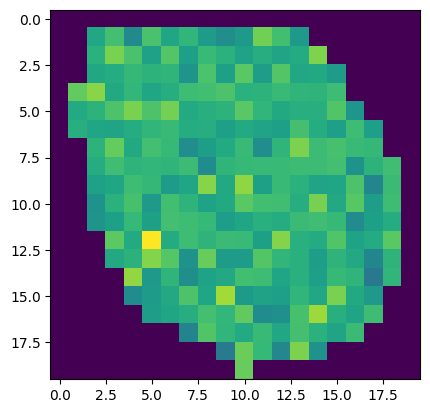

In [110]:
plt.imshow(aligned_new_X[0,0])

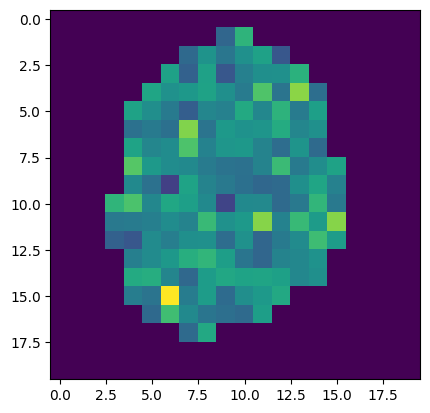

In [111]:
plt.imshow(x_train_previous[0])

In [28]:
aligned_new_X.shape

(2184, 1080, 20, 20)

In [71]:
aligned_new_X[200,1].max()

0.5954720351002631

In [315]:
x_train_previous[200].min()

0.0

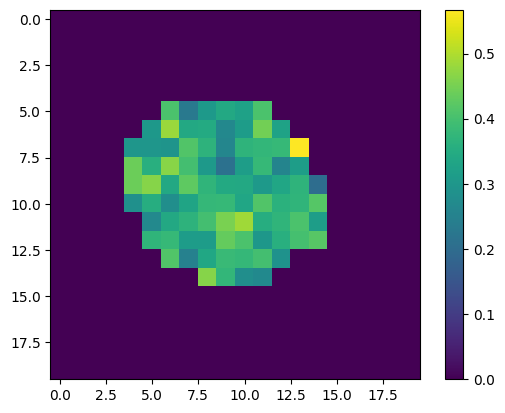

In [74]:
plt.imshow(aligned_new_X[200,0])
plt.colorbar()

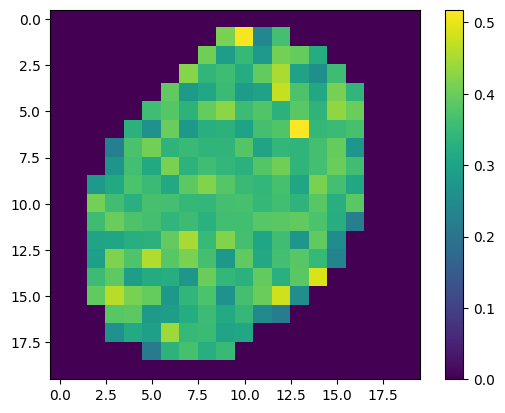

In [89]:
plt.imshow(x_train_previous[2])
plt.colorbar()

In [18]:
import numpy as np

def compute_intensity_stats(X):
    """
    Compute mean and standard deviation of each cell's first frame.
    """
    means = np.mean(X, axis=(1, 2))  # Compute mean per cell
    stds = np.std(X, axis=(1, 2))    # Compute std per cell
    return means, stds

def find_intensity_transform(prev_X, new_X):
    """
    Compute per-cell intensity scale and offset between previous and new X.
    Returns scale and offset per cell.
    """
    prev_means, prev_stds = compute_intensity_stats(prev_X)
    new_means, new_stds = compute_intensity_stats(new_X)

    # Compute scale and offset per cell
    scale = prev_stds / (new_stds + 1e-8)  # Avoid division by zero
    offset = prev_means - scale * new_means

    return scale, offset

def apply_intensity_transform(new_X, scale, offset):
    """
    Apply the computed transformation to all frames.
    """
    corrected_X = scale[:, None, None, None] * new_X + offset[:, None, None, None]
    return corrected_X


# Compute transformation
scale, offset = find_intensity_transform(x_train_previous, train_images_augmented[:,0])



In [19]:
# Apply to all frames
corrected_X = apply_intensity_transform(train_images_augmented, scale, offset)

In [20]:
corrected_X.shape

(2184, 1080, 20, 20)

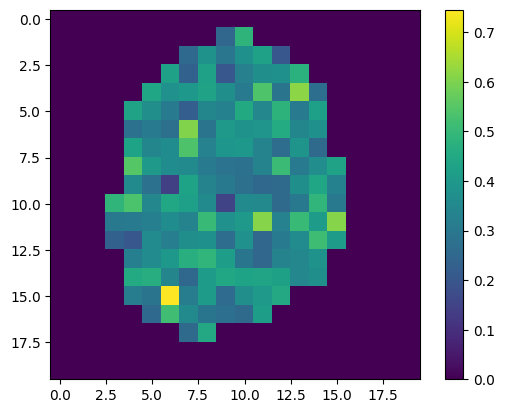

In [23]:
plt.imshow(x_train_previous[0])
plt.colorbar()

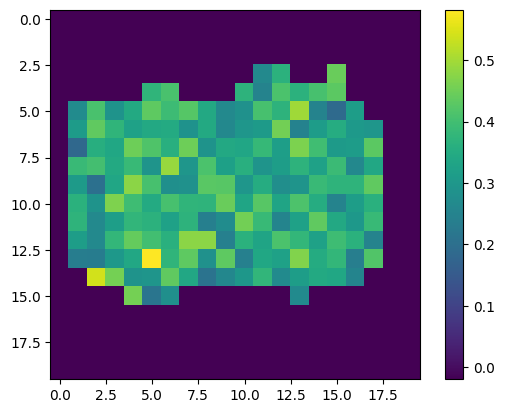

In [22]:
plt.imshow(corrected_X[0,0])
plt.colorbar()

## Tabular Data

In [147]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [139]:
### removing features that would bias the model decision (i.e., the fate of the cell, mitosis time, etc.)

train_tracks_features = train_tracks[:, :, 4:17 ] #[4,14,15,16] all features : 4:17
test_tracks_features = test_tracks[:, :, 4:17]

print(train_tracks_features.shape)

(1108, 1080, 13)


### Simple MLP (No hidden layers)

In [140]:
def simple_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

Using the first frame

In [126]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = simple_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6074 - loss: 0.7646 - val_accuracy: 0.1522 - val_loss: 3.1772
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6041 - loss: 0.7584 - val_accuracy: 0.2826 - val_loss: 1.5749
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6055 - loss: 0.7236 - val_accuracy: 0.4420 - val_loss: 1.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6054 - loss: 0.7412 - val_accuracy: 0.5000 - val_loss: 0.8256
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6194 - loss: 0.6937 - val_accuracy: 0.5435 - val_loss: 0.7357
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6358 - loss: 0.6450 - val_accuracy: 0.5652 - val_loss: 0.7005
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5987 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.6853
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6060 - loss: 0.6884 - val_accuracy: 0.58

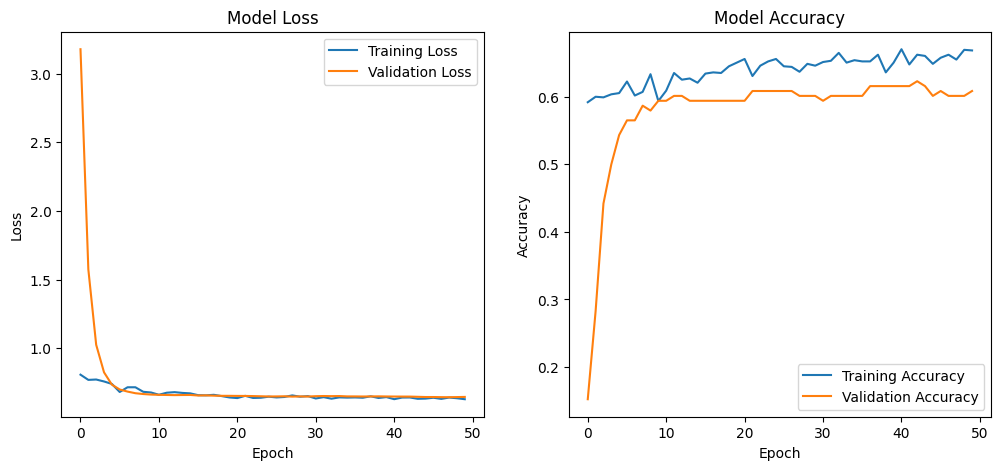

In [127]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[0.65765766 0.34234234]
 [0.5        0.5       ]]


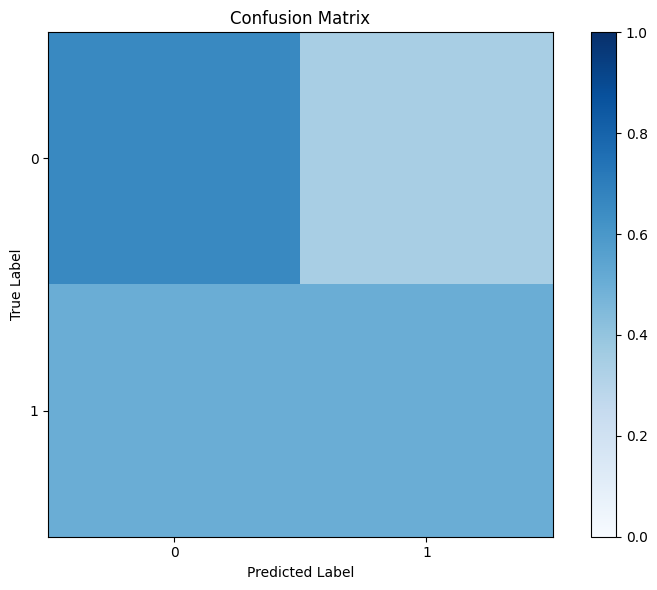

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### More Complex MLP 

In [149]:
def complex_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [157]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_28          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6917 - loss: 0.7303 - val_accuracy: 0.8043 - val_loss: 0.5844
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.6965 - val_accuracy: 0.7754 - val_loss: 0.6551
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5957 - loss: 0.6978 - val_accuracy: 0.4058 - val_loss: 0.7018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.5555 - loss: 0.6974 - val_accuracy: 0.4420 - val_loss: 0.7032
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5429 - loss: 0.6692 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5491 - loss: 0.6744 - val_accuracy: 0.4710 - val_loss: 0.6805
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.5491 - loss: 0.6501 - val_accuracy: 0.4855 - val_loss: 0.6691
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5449 - loss: 0.6531 - val_accuracy: 0.5435

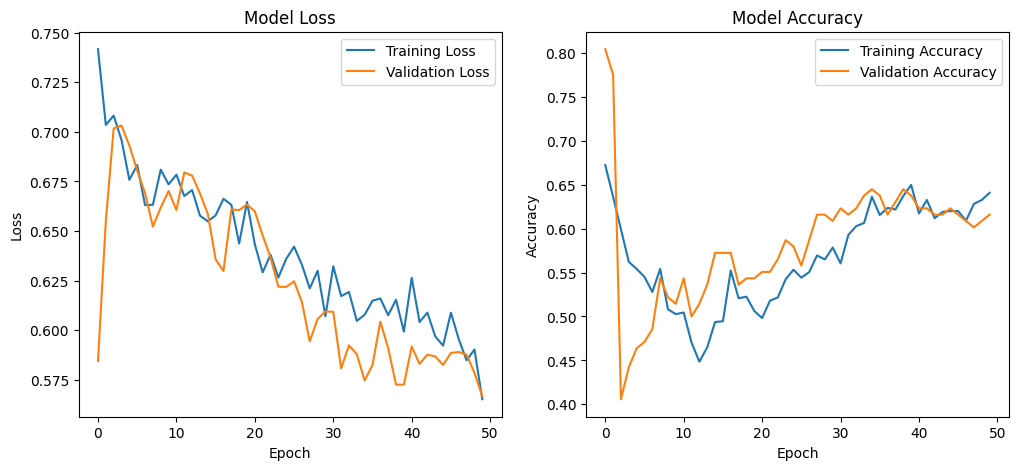

In [158]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[[0.63963964 0.36036036]
 [0.32142857 0.67857143]]
Precision:  0.6655507197857381


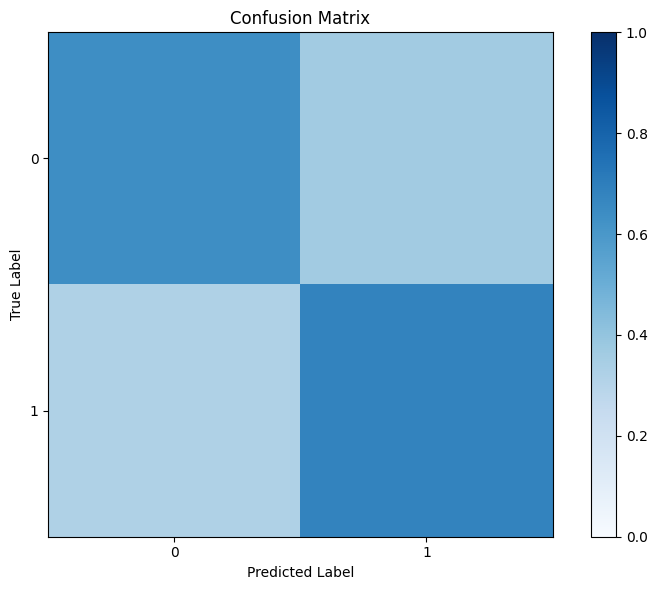

In [ ]:
num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

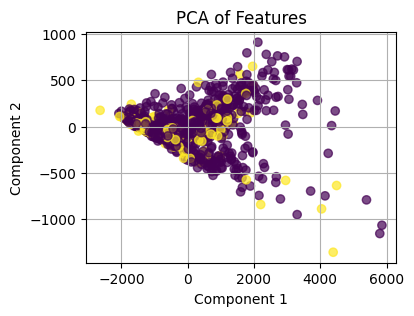

In [96]:
# Plot PCA of features to see if they are separable

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_tracks_features[:,frame,:])
X_pca = pca.transform(train_tracks_features[:,frame,:])

plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('PCA of Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

#### Temporal study

In [141]:
train_tracks_features = train_tracks[:, :, 4:17 ]
test_tracks_features = test_tracks[:, :, 4:17 ]

In [142]:
train_tracks_features.shape

(1108, 1080, 13)

In [143]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data


In [144]:
time_norm_train_track = normalize_cell_time(train_tracks_features)
time_norm_test_track = normalize_cell_time(test_tracks_features)

In [145]:
time_norm_train_track.shape, time_norm_test_track.shape

((1108, 11, 13), (277, 11, 13))

In [152]:
precisions = np.zeros((11, 1))
mean_diagonals = np.zeros((11, 1))

for i in range(11):
    frame = i
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(config['seed'])

    classifier = complex_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1]) #[:, [3, 8]] 
    #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(time_norm_test_track[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(time_norm_train_track[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = len(np.unique(train_labels))
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
    mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
    print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

    precisions[i] = precision
    mean_diagonals[i] = mean_diagonal


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6777 - loss: 0.7542 - val_accuracy: 0.8043 - val_loss: 0.5931
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.7059 - val_accuracy: 0.8188 - val_loss: 0.6393
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5235 - loss: 0.7127 - val_accuracy: 0.5290 - val_loss: 0.6843
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5351 - loss: 0.6937 - val_accuracy: 0.5072 - val_loss: 0.6876
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5121 - loss: 0.6792 - val_accuracy: 0.4638 - val_loss: 0.6797
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5070 - loss: 0.6980 - val_accuracy: 0.4928 - val_loss: 0.6750
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5357 - loss: 0.6572 - val_accuracy: 0.4928 - val_loss: 0.6700
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5343 - loss: 0.6672 - val_accuracy: 0.5217

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.7621 - val_accuracy: 0.8406 - val_loss: 0.5748
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6045 - loss: 0.7042 - val_accuracy: 0.8478 - val_loss: 0.6164
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5732 - loss: 0.7201 - val_accuracy: 0.5942 - val_loss: 0.6813
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5113 - loss: 0.7011 - val_accuracy: 0.4493 - val_loss: 0.6988
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.5064 - loss: 0.6778 - val_accuracy: 0.4203 - val_loss: 0.7034
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5187 - loss: 0.6883 - val_accuracy: 0.4710 - val_loss: 0.6892
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5451 - loss: 0.6602 - val_accuracy: 0.5072 - val_loss: 0.6858
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5391 - loss: 0.6772 - val_accuracy: 0.52

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6857 - loss: 0.7701 - val_accuracy: 0.8623 - val_loss: 0.5417
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6348 - loss: 0.7036 - val_accuracy: 0.8623 - val_loss: 0.5888
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5570 - loss: 0.7205 - val_accuracy: 0.6594 - val_loss: 0.6566
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5512 - loss: 0.6911 - val_accuracy: 0.5652 - val_loss: 0.6685
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5497 - loss: 0.6725 - val_accuracy: 0.5725 - val_loss: 0.6570
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5489 - loss: 0.6831 - val_accuracy: 0.5942 - val_loss: 0.6433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5871 - loss: 0.6348 - val_accuracy: 0.5580 - val_loss: 0.6461
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5346 - loss: 0.6659 - val_accuracy: 0.57

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 0.7681 - val_accuracy: 0.8623 - val_loss: 0.5357
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6508 - loss: 0.7035 - val_accuracy: 0.8551 - val_loss: 0.5954
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5889 - loss: 0.7111 - val_accuracy: 0.6087 - val_loss: 0.6610
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5563 - loss: 0.6876 - val_accuracy: 0.5362 - val_loss: 0.6706
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5147 - loss: 0.6733 - val_accuracy: 0.5290 - val_loss: 0.6687
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5649 - loss: 0.6762 - val_accuracy: 0.5652 - val_loss: 0.6510
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5921 - loss: 0.6500 - val_accuracy: 0.5290 - val_loss: 0.6613
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5741 - loss: 0.6515 - val_accuracy: 0.5290

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.7617 - val_accuracy: 0.8623 - val_loss: 0.5276
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.6368 - loss: 0.7056 - val_accuracy: 0.8188 - val_loss: 0.6017
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.5874 - loss: 0.7145 - val_accuracy: 0.6304 - val_loss: 0.6562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5489 - loss: 0.6916 - val_accuracy: 0.5652 - val_loss: 0.6619
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.5669 - loss: 0.6675 - val_accuracy: 0.5797 - val_loss: 0.6657
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5641 - loss: 0.6707 - val_accuracy: 0.5580 - val_loss: 0.6633
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5762 - loss: 0.6275 - val_accuracy: 0.5797 - val_loss: 0.6544
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5694 - loss: 0.6484 - val_accuracy: 0.60

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_6           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6981 - loss: 0.7527 - val_accuracy: 0.8623 - val_loss: 0.5340
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6213 - loss: 0.7045 - val_accuracy: 0.8478 - val_loss: 0.5831
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.5710 - loss: 0.7140 - val_accuracy: 0.6884 - val_loss: 0.6302
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5523 - loss: 0.6935 - val_accuracy: 0.6884 - val_loss: 0.6402
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5520 - loss: 0.6726 - val_accuracy: 0.6232 - val_loss: 0.6487
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5667 - loss: 0.6733 - val_accuracy: 0.6159 - val_loss: 0.6360
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5883 - loss: 0.6349 - val_accuracy: 0.6087 - val_loss: 0.6432
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5560 - loss: 0.6585 - val_accuracy: 0.6087

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6959 - loss: 0.7580 - val_accuracy: 0.8696 - val_loss: 0.5371
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.7025 - val_accuracy: 0.8696 - val_loss: 0.5694
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.5986 - loss: 0.7078 - val_accuracy: 0.7101 - val_loss: 0.6166
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5911 - loss: 0.6804 - val_accuracy: 0.6377 - val_loss: 0.6265
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5726 - loss: 0.6709 - val_accuracy: 0.5870 - val_loss: 0.6228
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5905 - loss: 0.6584 - val_accuracy: 0.5870 - val_loss: 0.6076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5821 - loss: 0.6286 - val_accuracy: 0.6014 - val_loss: 0.6062
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.6028 - loss: 0.6360 - val_accuracy: 0.6159

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6845 - loss: 0.7527 - val_accuracy: 0.8696 - val_loss: 0.5113
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6332 - loss: 0.7010 - val_accuracy: 0.8623 - val_loss: 0.5679
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6050 - loss: 0.7119 - val_accuracy: 0.6812 - val_loss: 0.6292
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5356 - loss: 0.6870 - val_accuracy: 0.6014 - val_loss: 0.6468
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5347 - loss: 0.6829 - val_accuracy: 0.5797 - val_loss: 0.6521
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5486 - loss: 0.6831 - val_accuracy: 0.5725 - val_loss: 0.6422
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5760 - loss: 0.6458 - val_accuracy: 0.5725 - val_loss: 0.6426
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5811 - loss: 0.6452 - val_accuracy: 0.6014

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6925 - loss: 0.7463 - val_accuracy: 0.8623 - val_loss: 0.5436
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6524 - loss: 0.6977 - val_accuracy: 0.8478 - val_loss: 0.6089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6101 - loss: 0.7048 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5578 - loss: 0.6951 - val_accuracy: 0.5072 - val_loss: 0.6523
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5378 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.6517
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5586 - loss: 0.6874 - val_accuracy: 0.5507 - val_loss: 0.6355
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5570 - loss: 0.6478 - val_accuracy: 0.5942 - val_loss: 0.6371
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5591 - loss: 0.6556 - val_accuracy: 0.5942

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7012 - loss: 0.7499 - val_accuracy: 0.8623 - val_loss: 0.5660
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.6135 - loss: 0.7068 - val_accuracy: 0.7826 - val_loss: 0.6303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5641 - loss: 0.7148 - val_accuracy: 0.5072 - val_loss: 0.6892
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5295 - loss: 0.7008 - val_accuracy: 0.4565 - val_loss: 0.6946
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5438 - loss: 0.6869 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5523 - loss: 0.6843 - val_accuracy: 0.5290 - val_loss: 0.6692
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5654 - loss: 0.6543 - val_accuracy: 0.5435 - val_loss: 0.6621
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.5706 - loss: 0.6570 - val_accuracy: 0.56

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7119 - loss: 0.7453 - val_accuracy: 0.8696 - val_loss: 0.4989
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7011 - val_accuracy: 0.8696 - val_loss: 0.5986
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5983 - loss: 0.7137 - val_accuracy: 0.6304 - val_loss: 0.6604
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.5342 - loss: 0.6981 - val_accuracy: 0.5580 - val_loss: 0.6744
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.5542 - loss: 0.6956 - val_accuracy: 0.5145 - val_loss: 0.6774
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5679 - loss: 0.6848 - val_accuracy: 0.5725 - val_loss: 0.6637
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.6013 - loss: 0.6571 - val_accuracy: 0.5870 - val_loss: 0.6502
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.5656 - loss: 0.6621 - val_accuracy: 0.5797

In [153]:
conf_matrix_normalized

array([[0.64864865, 0.35135135],
       [0.14285714, 0.85714286]])

In [154]:
precisions

array([[0.61615844],
       [0.6711554 ],
       [0.72456576],
       [0.74715262],
       [0.74004684],
       [0.74715262],
       [0.80340064],
       [0.83457526],
       [0.85298013],
       [0.77932406],
       [0.8195122 ]])

In [157]:
time_norm_test_track.shape

(277, 11, 13)

In [161]:
test_norm_images.shape

(277, 11, 20, 20)

In [159]:
test_norm_images = np.load('../data/images/time_norm_test_images.npy')

In [160]:
mean_diagonals

array([[0.61888674],
       [0.70447233],
       [0.70382883],
       [0.74436937],
       [0.73085586],
       [0.74436937],
       [0.77557915],
       [0.78893179],
       [0.75723938],
       [0.7260296 ],
       [0.75289575]])

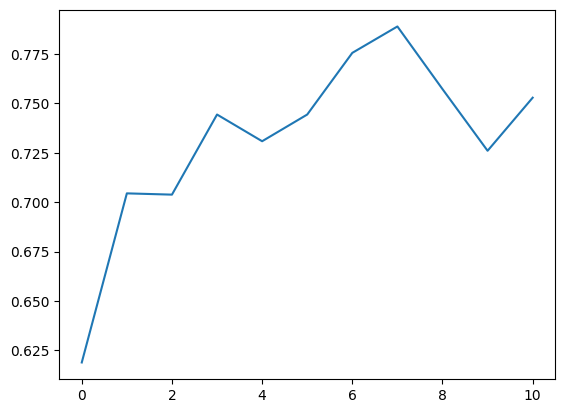

In [156]:
plt.plot(mean_diagonals)

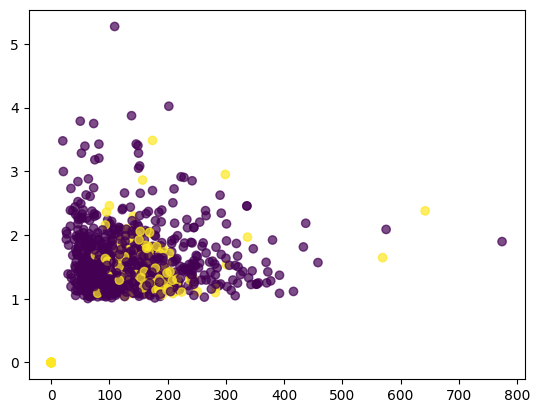

In [63]:
plt.scatter(time_norm_train_track[:,10,2], time_norm_train_track[:,10,3], c=train_labels.flatten(), cmap='viridis', alpha=0.7)

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

#### 2. Train AAE with Contrastive loss and Covariance loss

#### 3. Classify with MLP 

#### 4. Evaluation 

#### 5. Temporal study

In [57]:
import numpy as np

def normalize_cell_time_images(images):
    """
    Normalize cell time by extracting images at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - images: numpy array of shape (cells, time, height, width)
      (assumes a cell's lifetime is determined by nonzero pixel values)
    
    Returns:
    - normalized_images: numpy array of shape (cells, 11, height, width)
    """
    num_cells, num_timepoints, height, width = images.shape
    normalized_images = np.zeros((num_cells, 11, height, width))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero frames)
        lifetime = np.count_nonzero(np.sum(images[i], axis=(1, 2)))  # Sum over spatial dims to check for zeros
        #print(lifetime)
        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract images at these indices
        normalized_images[i] = images[i, indices, :, :]

    return normalized_images


In [58]:
train_images_augmented.shape

(2184, 1080, 20, 20)

In [59]:
time_norm_train_images = normalize_cell_time_images(stretched_x_train)
time_norm_test_images = normalize_cell_time_images(stretched_x_test)

In [60]:
time_norm_train_images.shape

(2184, 11, 20, 20)

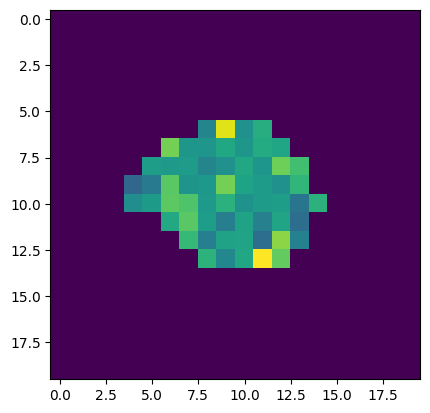

In [43]:
plt.imshow(train_images_augmented[200,10,:,:])

In [66]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 100
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=10, step=1, value=0)) # max=images.shape[0] - 1

display_movie(time_norm_train_images)

interactive(children=(IntSlider(value=0, description='frame', max=10), Output()), _dom_classes=('widget-intera…

In [63]:
np.save("../data/images/time_norm_train_images.npy", time_norm_train_images)
np.save("../data/images/time_norm_test_images.npy", time_norm_test_images)

#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification